In [36]:
import ee
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1Adeu5BUGlku5BPwpCT7BdhgAf32v_q5kWRdsPXxO3Jh-lAaggxj3eqkl8Y4

Successfully saved authorization token.


In [25]:
MODEL_INFO = {'UKESM1-0-LL': 'HadAM',
 'NorESM2-MM': 'CCM',
 'NorESM2-LM': 'CCM',
 'MRI-ESM2-0': 'UCLA GCM',
 'MPI-ESM1-2-LR': 'ECMWF',
 'MPI-ESM1-2-HR': 'ECMWF',
 'MIROC6': 'MIROC',
 'MIROC-ES2L': 'MIROC',
 'KIOST-ESM': 'GFDL',
 'KACE-1-0-G': 'HadAM',
 'IPSL-CM6A-LR': 'IPSL',
 'INM-CM5-0': 'INM',
 'INM-CM4-8': 'INM',
 'HadGEM3-GC31-MM': 'HadAM',
 'HadGEM3-GC31-LL': 'HadAM',
 'GFDL-ESM4': 'GFDL',
 'GFDL-CM4_gr2': 'GFDL',
 'GFDL-CM4': 'GFDL',
 'FGOALS-g3': 'CCM',
 'EC-Earth3-Veg-LR': 'ECMWF',
 'EC-Earth3': 'ECMWF',
 'CanESM5': 'CanAM',
 'CNRM-ESM2-1': 'ECMWF',
 'CNRM-CM6-1': 'ECMWF',
 'CMCC-ESM2': 'CCM',
 'CMCC-CM2-SR5': 'CCM',
 'BCC-CSM2-MR': 'CCM',
 'ACCESS-ESM1-5': 'HadAM',
 'ACCESS-CM2': 'HadAM',
 'TaiESM1': 'CCM',
}

EXCLUDED_MODELS = ['GFDL-CM4_gr2','ERA5'] 

MODELS = [i for i in MODEL_INFO if not i in EXCLUDED_MODELS]


INITIAL_LATLON = (22.5276, 88.3639)  # Kolkata

HIST_START = 1980
HIST_END = 2014
FUTURE_START = 2050
FUTURE_END = 2070

STUDY_THRESH = 40

NUM_BEST_MODELS = 3

shift_years = False

In [3]:
def d2j(datestring):
    d = datetime.date.fromisoformat(datestring)
    jday = d.timetuple().tm_yday
    if calendar.isleap(d.year) and jday > 59:
        jday -= 1
    return jday

In [4]:
def get_var(varname, model, latlon, start_year=HIST_START, end_year=HIST_END, yearshift=False, scenario='ssp585'):
    def removeLeapDays(arr, yearshift=False):
        if not yearshift:
            indices = []
            jan1_idx = 0
            for year in range(start_year, end_year+1):
                indices += [jan1_idx + i for i in range(365)]
                jan1_idx += 365
                if calendar.isleap(year):
                    jan1_idx += 1
            return arr[indices]
        else:
            indices = []
            jul1_idx = 0
            for year in range(start_year-1, end_year):
                indices += [jul1_idx + i for i in range(183)]
                jul1_idx += 183
                if calendar.isleap(year):
                    jul1_idx += 1
                indices += [jul1_idx + i for i in range(182)]
                jul1_idx += 182
            return arr[indices]
    if model != 'ERA5' and start_year < 2015 and end_year >= 2015:
        raise Exception("Requesting hist and non-hist variables in one query")
    if model == 'ERA5':
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
    else:
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(end_year<2015)]))
    gee_geom = ee.Geometry.Point((latlon[1], latlon[0]))
    if not yearshift:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-01-01'.format(start_year), '{0}-01-01'.format(end_year+ 1)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), False)
    else:
        data_vars = dataset.select(varname).filter(ee.Filter.date('{0}-07-01'.format(start_year-1), '{0}-07-01'.format(end_year)))
        result = [i[4] for i in data_vars.getRegion(gee_geom, 2500, 'epsg:4326').getInfo()[1:]]
        return removeLeapDays(np.array(result), True)

In [5]:
def get_rmsd(d1, d2):
    def seasonal_means(d):
        mam = []  # 60-151
        jja = []  # 152-243
        son = []  # 244-334
        djf = []  # 335-59
        jan1_idx = 365 + [0, 1][int(calendar.isleap(HIST_START))]
        for year in range(HIST_START+1, HIST_END):
            mam.append(d[jan1_idx + 60 : jan1_idx + 152])
            jja.append(d[jan1_idx + 152 : jan1_idx + 244])
            son.append(d[jan1_idx + 244 : jan1_idx + 335])
            if year < HIST_END - 1:
                if False and calendar.isleap(year):
                    yearlength = 366
                else:
                    yearlength = 365
                djf.append(np.concatenate((d[jan1_idx + 335 : jan1_idx + 365], d[jan1_idx + yearlength : jan1_idx + yearlength + 60])))
            else:
                djf.append(np.concatenate((d[335 : 365], d[365 + [0, 1][int(False and calendar.isleap(HIST_START))] : 425])))
            jan1_idx += 365 + [0, 1][int(False and calendar.isleap(year))]
        return np.array([np.mean(mam, axis=1), np.mean(jja, axis=1), np.mean(son, axis=1), np.mean(djf, axis=1)]).flatten()
            
    c1 = seasonal_means(d1)
    c2 = seasonal_means(d2)
    return np.sqrt(np.mean(np.sum((c1 - c2)**2)))

In [9]:
def quarters(d, start_year, end_year):
    mam = []  # 60-151
    jja = []  # 152-243
    son = []  # 244-334
    djf = []  # 335-59
    jan1_idx = 365# + [0, 1][int(calendar.isleap(start_year))]
    for year in range(start_year, end_year):
        tmp = np.concatenate((d[jan1_idx - 365 : jan1_idx - 365 + 60], d[jan1_idx + 335 : jan1_idx + 365]), axis=0)
        djf.append(tmp)
        mam.append(d[jan1_idx + 60 : jan1_idx + 152])
        jja.append(d[jan1_idx + 152 : jan1_idx + 244])
        son.append(d[jan1_idx + 244 : jan1_idx + 335])

        jan1_idx += 365 + [0, 0][int(False and calendar.isleap(year))]
    mam_res = np.vstack(mam)
    jja_res = np.vstack(jja)
    son_res = np.vstack(son)
    djf_res = np.vstack(djf)
    return mam_res, jja_res, son_res, djf_res
    
def seasonal_means(d):
    q = quarters(d, HIST_START, HIST_END)
    return np.array([np.mean(q[0], axis=1), np.mean(q[1], axis=1), np.mean(q[2], axis=1), np.mean(q[3], axis=1)])

In [83]:
def calibration_function(hist_obs, hist_mod):
    source = np.sort(hist_obs.flatten())
    target= np.sort(hist_mod.flatten())
   
    if (np.max(source) == 0 and np.min(source) == 0):
        return np.arange(0, target.size) / target.size
    if (np.max(target) == 0 and np.min(target) == 0):
        return np.arange(0, source.size) / source.size
    new_indices = []
    #source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        if target_idx < len(source):
            source_value = source[target_idx]
            if source_value > target[-1]:
                new_indices.append(target.size - 1)
            else:
                new_indices.append(np.argmax(target >= source_value))
    return np.array(new_indices) / source.size

def calibrate_component(uncalibrated_data, calibration_fxn):
    N = len(uncalibrated_data)
    unsorted_uncalib = [(i, idx) for idx, i in enumerate(uncalibrated_data)]
    sorted_uncalib = sorted(unsorted_uncalib)
    result = [0] * N
    for j in range(N):
        X_j = j / (N + 1)
        Y_jprime = calibration_fxn[math.floor(X_j * len(calibration_fxn))]
        jprime = math.floor(Y_jprime * (N + 1))
        result[sorted_uncalib[j][1]] = sorted_uncalib[min(len(sorted_uncalib)-1, jprime)][0]
    
    return result

def calibrate(uncalibrated_data, calibration_fxn):
    mam = []
    jja = []
    son = []
    djf = []
    mam_idx = []
    jja_idx = []
    son_idx = []
    djf_idx = []
    for idx, i in enumerate(uncalibrated_data):
        if idx % 365 >= 60 and idx % 365 < 152:
            mam.append(uncalibrated_data[idx])
            mam_idx.append(idx)
        elif idx % 365 >= 152 and idx % 365 < 244:
            jja.append(uncalibrated_data[idx])
            jja_idx.append(idx)
        elif idx % 365 >= 244 and idx % 365 < 335:
            son.append(uncalibrated_data[idx])
            son_idx.append(idx)
        else:
            djf.append(uncalibrated_data[idx])
            djf_idx.append(idx)
    
    mam_calib = calibrate_component(np.array(mam), calibration_fxn[0])
    jja_calib = calibrate_component(np.array(jja), calibration_fxn[1])
    son_calib = calibrate_component(np.array(son), calibration_fxn[2])
    djf_calib = calibrate_component(np.array(djf), calibration_fxn[3])
    
    result = [0] * len(uncalibrated_data)
    for i in range(len(mam_idx)):
        result[mam_idx[i]] = mam_calib[i]
    for i in range(len(jja_idx)):
        result[jja_idx[i]] = jja_calib[i]
    for i in range(len(son_idx)):
        result[son_idx[i]] = son_calib[i]
    for i in range(len(djf_idx)):
        result[djf_idx[i]] = djf_calib[i]

    return np.array(result)

In [26]:
# Select three best models based on RMSD of quarterly mean tasmax
hist_obs = get_var('maximum_2m_air_temperature', 'ERA5', INITIAL_LATLON)
hist_mods = {}
rmsds = []
for model in MODELS:
    hist_mod = get_var('tasmax', model, INITIAL_LATLON, start_year=HIST_START-1)
    hist_mods[model] = hist_mod
    rmsds.append((get_rmsd(hist_obs, hist_mod), model))
rmsds.sort()
best_models = []
families = []
idx = 0
while len(best_models) < 3:
    if not MODEL_INFO[rmsds[idx][1]] in families:
        best_models.append(rmsds[idx][1])
        families.append(MODEL_INFO[rmsds[idx][1]])
    idx += 1
    
for m in best_models:
    print(m, [i[0] for i in rmsds if i[1]==m][0])

NorESM2-LM 15.604376533370058
ACCESS-ESM1-5 15.877571315517939
MIROC-ES2L 15.987326373101315


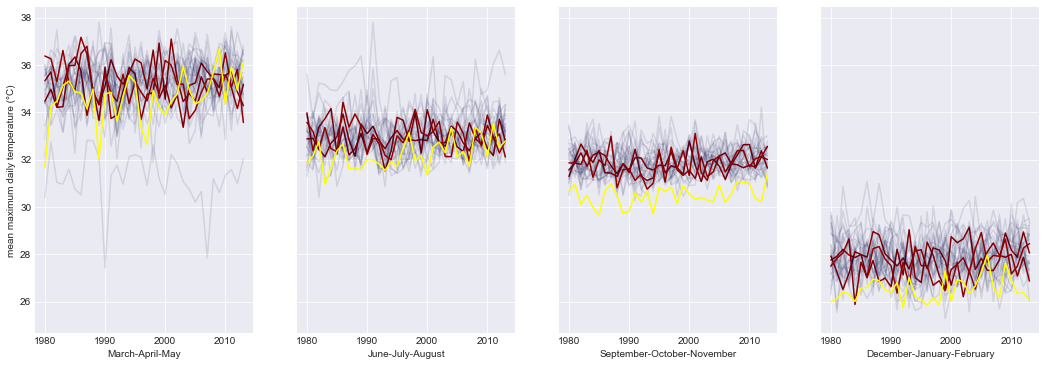

<Figure size 648x288 with 0 Axes>

In [27]:
fig, (mam, jja, son, djf) = plt.subplots(1, 4, sharey=True, figsize=(18, 6))
plt.figure(figsize=(9,4))
for season in range(4):
    ax = [mam, jja, son, djf][season]
    for model in hist_mods:
        ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_mods[model] - 273.15)[season], color=['#000040', '#900000'][int(model in best_models)], alpha=[0.1, 1][int(model in best_models)])
    ax.plot([HIST_START + i for i in range(HIST_END - HIST_START)], seasonal_means(hist_obs)[season] - 273.15, color="#ffff00")
    if season == 0:
        ax.set_ylabel('mean maximum daily temperature (°C)')
    ax.set_xlabel(['March-April-May', 'June-July-August', 'September-October-November', 'December-January-February'][season])

In [74]:
for quarter in range(4):
    obs_10 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 10)
    obs_90 = np.percentile(quarters(hist_obs, HIST_START, HIST_END)[quarter], 90)
    for model in best_models:
        mod = quarters(hist_mod[model], HIST_START, HIST_END)[quarter].flatten()
        print('{0}: min modeled value does not exceed observed 10th percentile  {1}'.format(model, min(mod) <= obs_10))
        print('{0}: max modeled value does not exceed observed 90th percentile  {1}'.format(model, max(mod) >= obs_90))


NorESM2-LM: min modeled value does not exceed observed 10th percentile  True
NorESM2-LM: max modeled value does not exceed observed 90th percentile  True
ACCESS-ESM1-5: min modeled value does not exceed observed 10th percentile  True
ACCESS-ESM1-5: max modeled value does not exceed observed 90th percentile  True
MIROC-ES2L: min modeled value does not exceed observed 10th percentile  True
MIROC-ES2L: max modeled value does not exceed observed 90th percentile  True
NorESM2-LM: min modeled value does not exceed observed 10th percentile  True
NorESM2-LM: max modeled value does not exceed observed 90th percentile  True
ACCESS-ESM1-5: min modeled value does not exceed observed 10th percentile  True
ACCESS-ESM1-5: max modeled value does not exceed observed 90th percentile  True
MIROC-ES2L: min modeled value does not exceed observed 10th percentile  True
MIROC-ES2L: max modeled value does not exceed observed 90th percentile  True
NorESM2-LM: min modeled value does not exceed observed 10th perc

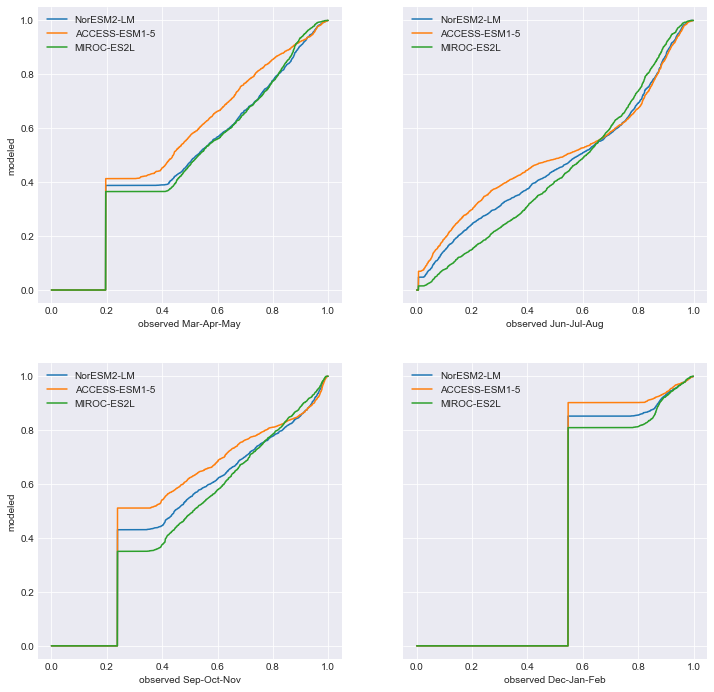

In [45]:
# Get precip calibration functions

calibration_fxn = {}
hist_mod = {}

hist_obs = get_var('total_precipitation', 'ERA5', INITIAL_LATLON) * 1000
#plt.figure(figsize=(12, 2.5))
for model in best_models:
    hist_mod[model] = get_var('pr', model, INITIAL_LATLON, yearshift = shift_years) * 86400
    o_quarters = quarters(hist_obs, HIST_START, HIST_END)
    m_quarters = quarters(hist_mod[model], HIST_START, HIST_END)
    calibration_fxn[model] = [calibration_function(o_quarters[i].flatten(), m_quarters[i].flatten()) for i in range(4)]
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True, figsize=(12, 12))
for i in range(4):
    ax = (ax0, ax1, ax2, ax3)[i]
    for model in best_models:
        ax.plot([j/(len(calibration_fxn[model][i])+1) for j in range(len(calibration_fxn[model][i]))], calibration_fxn[model][i], label=model)
        ax.set_xlabel('observed {}'.format(['Mar-Apr-May', 'Jun-Jul-Aug', 'Sep-Oct-Nov', 'Dec-Jan-Feb'][i]))
        ax.legend()
ax0.set_ylabel('modeled')
ax2.set_ylabel('modeled')
plt.show()

In [40]:
fut_mod = {}
for model in best_models:
    fut_mod[model] = get_var('tasmax', model, INITIAL_LATLON, start_year=FUTURE_START, end_year=FUTURE_END)

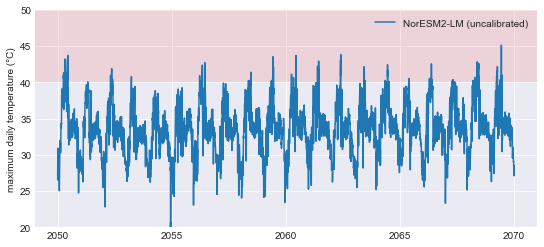

In [81]:
# Plot future modeled time series of UNCALIBRATED tasmax

plt.figure(figsize=(9, 4))
for model in list(fut_mod.keys())[:1]:
    plt.plot([2050 + (i/365) for i in range(365*20)], fut_mod[model][:-365]-273.15, label='{0} (uncalibrated)'.format(model))
    count = np.sum(np.sum((np.array(fut_mod[model])-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(20,50)
plt.axhspan(STUDY_THRESH, plt.axis()[3], facecolor='r', alpha=0.1)
plt.ylabel('maximum daily temperature (°C)')
#plt.text(2050, 45, '{0} days with max temp ≥ {1}C during 2050-2070 ({2} years with 10+ days)'.format(np.sum(fut_mod[model]-273.15 >= STUDY_THRESH), STUDY_THRESH, count), fontsize=30)
plt.legend(loc='upper right')
plt.show()

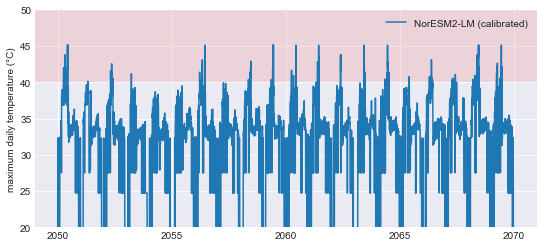

In [84]:
# Plot future modeled time series of CALIBRATED tasmax

plt.figure(figsize=(9,4))
for model in list(fut_mod.keys())[:1]:
    calib_data = np.array(calibrate(fut_mod[model]-273.15, calibration_fxn[model]))
    plt.plot([2050 + (i/365) for i in range(365*20)], calib_data[:-365], label='{0} (calibrated)'.format(model))
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
plt.xticks(ticks=[y for y in range(FUTURE_START, FUTURE_END+1) if y % 5 == 0])
plt.ylim(20,50)
plt.axhspan(STUDY_THRESH, plt.axis()[3], facecolor='r', alpha=0.1)
plt.ylabel('maximum daily temperature (°C)')
#plt.text(2050, 45, '{0} days with max temp ≥ {1}C during 2050-2070 ({2} years with 10+ days)'.format(np.sum(calib_data >= STUDY_THRESH), STUDY_THRESH, count), fontsize=30)
plt.legend()
plt.show()

In [85]:
for model in list(fut_mod.keys()):
    calib_data = np.array(calibrate(fut_mod[model]-273.15, calibration_fxn[model]))
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
    print(model, count)

NorESM2-LM 12
ACCESS-ESM1-5 18
MIROC-ES2L 15


In [86]:
def get_beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

In [87]:
posterior_ps = {}
for model in fut_mod:
    count = np.sum(np.sum((np.array(calibrate(fut_mod[model], calibration_fxn[model]))-273.15 >=40).reshape((FUTURE_END-FUTURE_START+1, 365)), axis=1)>=10)
    posterior_ps[model] = get_beta(count, FUTURE_END - FUTURE_START + 1, 10000)

In [51]:
posterior_counts = {}
for model in posterior_ps:
    for n in range(365):
        posterior_counts[model] = np.random.binomial(FUTURE_END - FUTURE_START + 1, posterior_ps[model], 10000)

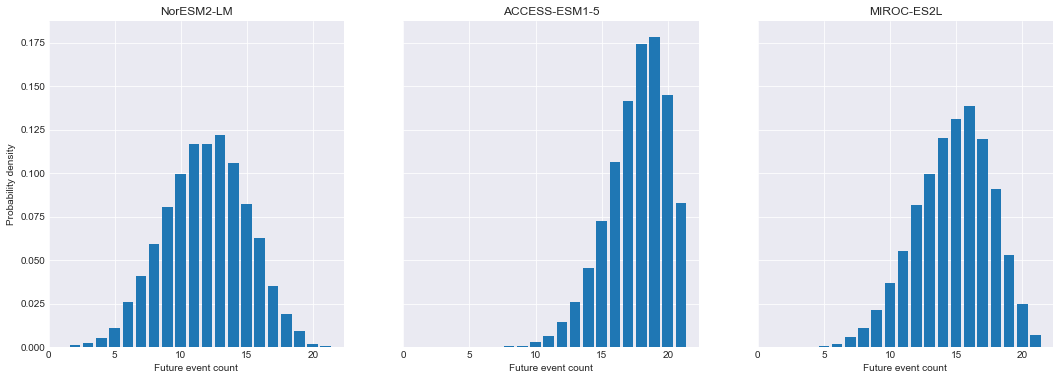

In [63]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(18, 6))
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[0]], bins=1000)
hist0 = ax0.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax0.set_title(list(posterior_counts.keys())[0])
ax0.set_xticks([i for i in range(22) if i % 5 == 0])
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[1]], bins=1000)
hist1 = ax1.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax1.set_title(list(posterior_counts.keys())[1])
ax1.set_xticks([i for i in range(22) if i % 5 == 0])
hist = np.histogram(posterior_counts[list(posterior_counts.keys())[2]], bins=1000)
hist2 = ax2.bar(hist[1][:-1], hist[0]/np.sum(hist[0]))
ax2.set_title(list(posterior_counts.keys())[2])
ax2.set_xticks([i for i in range(22) if i % 5 == 0])
ax0.set_ylabel('Probability density')
ax0.set_xlabel('Future event count')
ax1.set_xlabel('Future event count')
ax2.set_xlabel('Future event count')
plt.show()

In [56]:
for model in posterior_counts:
    print('{0}: {1}'.format(model, np.sum(posterior_counts[model]) / 10000))

NorESM2-LM: 11.9008
ACCESS-ESM1-5: 17.6559
MIROC-ES2L: 14.7777
